In [37]:
import csv
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
import skimage as sk
import cv2

In [ ]:
os.makedirs('/kaggle/working/final')

# Read 

In [41]:
# data dir
negDir = Path('/kaggle/input/surface-crack-detection/Negative')
posDir = Path('/kaggle/input/surface-crack-detection/Positive') 

In [42]:
pos_pahts_lst = list(posDir.glob(r'*.jpg'))
neg_pahts_lst = list(negDir.glob(r'*.jpg'))
print(len(pos_pahts_lst)) # 20000
print(len(neg_pahts_lst)) # 20000

20000
20000


In [3]:
def showImages(images,titles):
    fig,ax = plt.subplots(1, len(images),figsize=(10,10))
    i=0
    for image,title in zip(images,titles):
        ax[i].imshow(image,cmap='gray')
        ax[i].set_title(title)
        i=i+1
    plt.show()

# FEATURES

In [43]:
def getEdges(gray):
    gray = cv2.GaussianBlur(gray, (9, 9), 0)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3) 
    return np.sum(edges == 255)

In [44]:
def getWhiteToBlackRatio(image):
    number_of_white_pix = np.sum(image == 255)
    number_of_black_pix = np.sum(image == 0)
    return float(number_of_white_pix)/float(number_of_black_pix)

In [45]:
def get_number_of_contours_and_bw_ratio(image):
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    number_of_contours =len(cnts)
    BW_Ration=getWhiteToBlackRatio(thresh)
    return number_of_contours,BW_Ration

In [46]:
def get_number_of_contours_using_masking_and_MaxArea(image):
    image = cv2.GaussianBlur(image, (5, 5), 0)
    x = int(sk.filters.threshold_otsu(image))
    mask = cv2.inRange(image,0,x)
    # plt.imshow(mask,cmap='gray')

    contours,hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image,contours,-1,(0,0,255),2)
    # cv2.imshow('image',image)
#     plt.imshow(image,cmap='gray')
    max_area = 0
    w=0
    h=0
    for c in contours:
        area = cv2.contourArea(c)
        if area > max_area:
            max_area = area;
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),2)
            cv2.drawContours(image,c,-1,(255,0,0),2)

#     showImages([],'countours')  
    return len(contours),max_area

In [47]:
def get_RMS_contrast(img_grey): #Root mean square (RMS) contrast does not depend on the angular frequency content or the spatial distribution of contrast in the image.
    img_grey = cv2.GaussianBlur(img_grey, (9, 9), 0)
    return img_grey.std()

In [48]:
def getgrabcut_mask_ones(original_image):  #takes the RGB photo not the gray
    # masks the forGround then gets the mask ones as an indecator of the froground size
    height, width, _ = original_image.shape
    left_margin_proportion = 0.3
    right_margin_proportion = 0.3
    up_margin_proportion = 0.1
    down_margin_proportion = 0.1

    boundary_rectangle = (
        int(width * left_margin_proportion),
        int(height * up_margin_proportion),
        int(width * (1 - right_margin_proportion)),
        int(height * (1 - down_margin_proportion)),
    )

    # Set the seed for reproducibility purposes
    cv2.setRNGSeed(0)

    # Initialize GrabCut mask image, that will store the segmentation results
    mask = np.zeros((height, width), np.uint8)

    # Arrays used by the algorithm internally
    background_model = np.zeros((1, 65), np.float64)
    foreground_model = np.zeros((1, 65), np.float64)

    number_of_iterations = 5

    cv2.grabCut(
        img=original_image,
        mask=mask,
        rect=boundary_rectangle,
        bgdModel=background_model,
        fgdModel=foreground_model,
        iterCount=number_of_iterations,
        mode=cv2.GC_INIT_WITH_RECT,
    )


    grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype(
        "uint8"
    )
    grabcut_mask_ones = np.sum(grabcut_mask == 1)

    segmented_image = original_image.copy() * grabcut_mask[:, :, np.newaxis]
    return grabcut_mask_ones
#     plt.imshow(segmented_image,cmap='gray')

In [49]:
def variance_img(image):
    return np.var(image)

In [50]:
import PIL 
import cv2
IMG_HEIGHT = 150
IMG_WIDTH = 150
# datax = []
# labelsy = []
data_pos=[]
testCount = 0
# load images from posDir
label=1
for p in pos_pahts_lst:
#     print(p)
    image = cv2.imread(str(p))
#     print(str(p))
#     image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    img2= image.copy()
    grabcut_mask_ones = getgrabcut_mask_ones(img2) #feature 1
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = image/255
    img2= image.copy()
    var = variance_img(img2)#feature 2
    RMS_cont = get_RMS_contrast(img2) #feature 3
    img2= image.copy()
    num_of_contours_using_masking , max_area = get_number_of_contours_using_masking_and_MaxArea(img2)#feature 4,5
    img2= image.copy()
    edges = getEdges(img2) # feature 6
    img2= image.copy()
    num_of_contours_using_threshhold,bw_ratio = get_number_of_contours_and_bw_ratio(img2) #feature 7,8
    data_pos.append( [grabcut_mask_ones,var,RMS_cont,num_of_contours_using_masking,max_area,edges,num_of_contours_using_threshhold,bw_ratio,label])

#     if testCount == 10:
#         break
    if testCount%1000==0:
        print(testCount)
    testCount+=1
    
# print(data_pos)
print(testCount)




0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [51]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
# datax = []
# labelsy = []
testCount = 0
data_neg=[]
# load images from posDir
label=0
for p in neg_pahts_lst:
#     print(p)
    image = cv2.imread(str(p))
#     image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    img2= image.copy()
    grabcut_mask_ones = getgrabcut_mask_ones(img2) #feature 1
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = image/255
    img2= image.copy()
    var = variance_img(img2)#feature 2
    RMS_cont = get_RMS_contrast(img2) #feature 3
    img2= image.copy()
    num_of_contours_using_masking , max_area = get_number_of_contours_using_masking_and_MaxArea(img2)#feature 4,5
    img2= image.copy()
    edges = getEdges(img2) # feature 6
    img2= image.copy()
    num_of_contours_using_threshhold,bw_ratio = get_number_of_contours_and_bw_ratio(img2) #feature 7,8
    data_neg.append( [grabcut_mask_ones,var,RMS_cont,num_of_contours_using_masking,max_area,edges,num_of_contours_using_threshhold,bw_ratio,label] )

#     if testCount == 10:
#         break
    if testCount%1000==0:
        print(testCount)
    testCount+=1
# print(data_neg)
print(testCount)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [52]:
csv_headers=['grabcut_mask_ones','var','RMS_cont','num_of_contours_using_masking','max_area','edges','num_of_contours_using_threshhold','bw_ratio','label'] #features and lables


file = open('features.csv','w') #newLine is used to avoid some errors
writer = csv.writer(file)
writer.writerow(csv_headers)
writer.writerows(data_pos)
writer.writerows(data_neg)

file.close()


In [26]:
image = cv2.imread('/kaggle/input/surface-crack-detection/Negative/01501.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


(155, 1.0567995848800542)


In [22]:
#https://stackoverflow.com/questions/62042172/how-to-remove-noise-in-image-opencv-python
# Load image, grayscale, Otsu's threshold
image = cv2.imread('/kaggle/input/surface-crack-detection/Positive/01501.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# print(image.shape)
# image = sk.filters.sobel(image)
# plt.imshow(image,cmap='gray') 
thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
# plt.imshow(thresh,cmap='gray')


# # Find contours and perform contour approximation
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

number_of_contours =len(cnts)
print(number_of_contours)
n=getWhiteToBlackRatio(thresh)
print(n)

#To calculate the number of edges, you can use contour approximation. 
# The idea is that a curve can be approximated by a series of short line segments. 
# This leads to a resulting approximated curve that consists of a subset of points 
# defined by the original curve.



12
0.14435141797508272


In [28]:
image = cv2.imread('/kaggle/input/surface-crack-detection/Positive/19812.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(image)
img2= image.copy()
ln,maxx = get_number_of_contours_using_masking_and_MaxArea(img2)
print(f'num represting the contours is: {ln} .. and the largest contour area is: {maxx}')
# showImages([image,img2],['OG','new'])


num represting the contours is: 4 .. and the largest contour area is: 20180.0


num represting the contours is: 12 .. and the BlackWhite pixels ration is: 0.14435141797508272


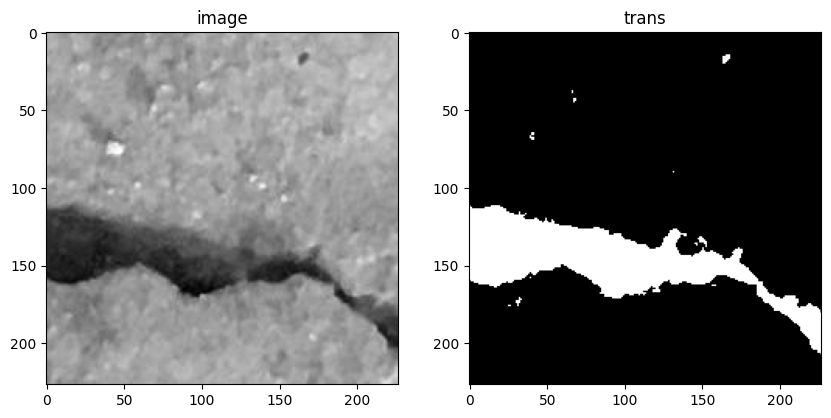

In [22]:
image = cv2.imread('/kaggle/input/surface-crack-detection/Positive/01501.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(image,cmap='gray')
new_image,contours,bwRatio = get_number_of_contours_and_bw_ratio(image)
print(f'num represting the contours is: {contours} .. and the BlackWhite pixels ration is: {bwRatio}')
showImages([image,new_image],['image','trans'])

In [34]:
image = cv2.imread('/kaggle/input/surface-crack-detection/Negative/02501.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(image,cmap='gray')
contours,bwRatio = get_number_of_contours_and_bw_ratio(image)
print(f'num represting the contours is: {contours} .. and the BlackWhite pixels ration is: {bwRatio}')
# showImages([image,new_image],['image','trans'])

num represting the contours is: 102 .. and the BlackWhite pixels ration is: 0.6965955485315423


num represting the contours is: 12 .. and the largest contour area is: 6106.0


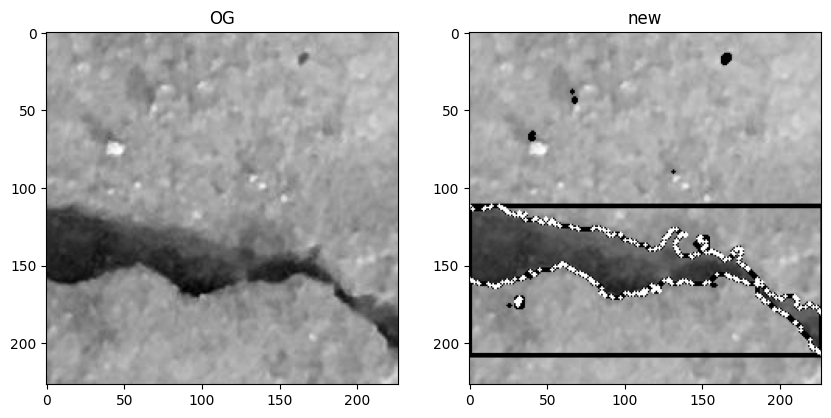

In [31]:
image = cv2.imread('/kaggle/input/surface-crack-detection/Positive/01501.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(image)
img2= image.copy()
img2,ln,maxx = get_number_of_contours_using_masking_and_MaxArea(img2)
print(f'num represting the contours is: {ln} .. and the largest contour area is: {maxx}')
showImages([image,img2],['OG','new'])


num represting the contours is: 59 .. and the largest contour area is: 25151.5


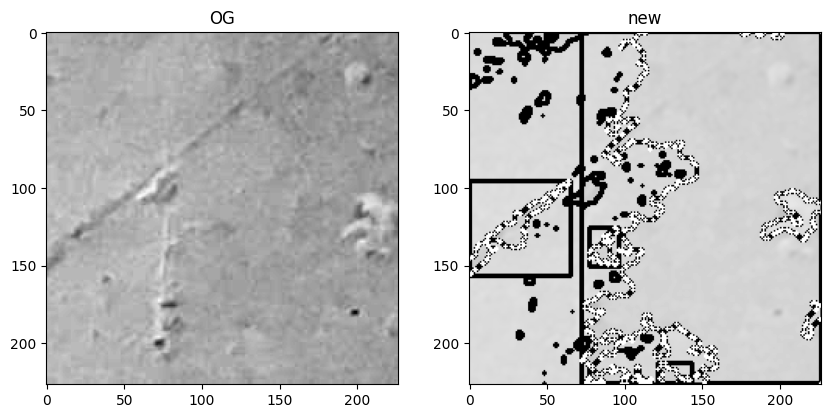

In [37]:
image = cv2.imread('/kaggle/input/surface-crack-detection/Negative/01501.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(image)
img2= image.copy()
img2,ln,maxx = get_number_of_contours_using_masking_and_MaxArea(img2)
print(f'num represting the contours is: {ln} .. and the largest contour area is: {maxx}')
showImages([image,img2],['OG','new'])

300


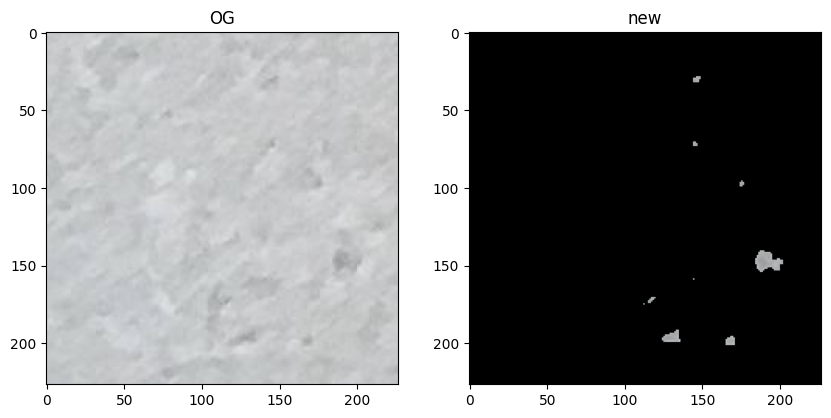

In [21]:
import cv2
import numpy as np

# Binarize input image
original_image = cv2.imread('/kaggle/input/surface-crack-detection/Negative/01701.jpg')
# gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
new_image = getgrabcut_mask_ones(original_image)
showImages([original_image,new_image],['OG','new'])



5112


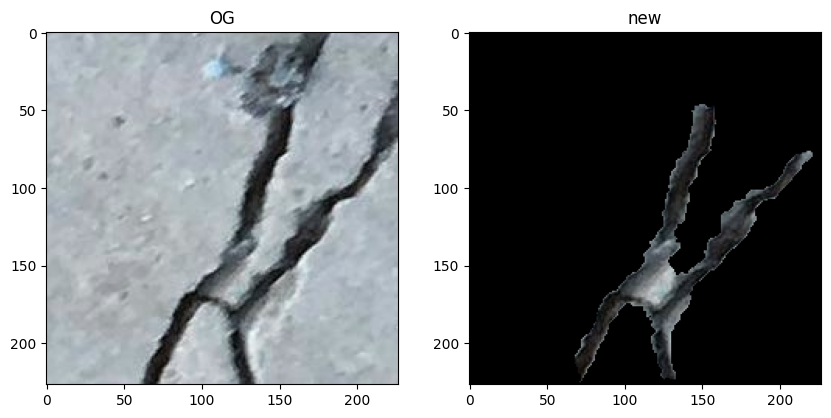

In [27]:
# Binarize input image
original_image = cv2.imread('/kaggle/input/surface-crack-detection/Positive/01001.jpg')
new_image = getgrabcut_mask_ones(original_image)
showImages([original_image,new_image],['OG','new'])